# Assignment1: Logistic Regression, SGD, and Regularization

In this lab session we will implement a Logistic Regression model for __sentence classification__ using Tensorflow. Given a sentence our model will predict if it is a positive or negative piece of text. The dataset we are going to use ranges the polarity annotation from 0 to 5, where 0 denotes extremely negative sentiment,  and 5  is the most  positive. 

Nevertheless, for this lab we'll  simplify the task, and we will translate the 5-way classification task into 2-way classification task (0 $\rightarrow$ _negative,_ ;1 $\rightarrow$ positive),


All in all, the main __objectives__ of this first assignment are the following: 
- Learn how to build, train and evaluate a Logistic Regression Model in Tensorflow.
- Implement L2 reguralization (see Assignment section on the bottom)
- Preprocessing of the input (e.g. one-hot-encoding)
- Explore hyperparameters like:
  - Learning Rates
  - Regularization weight
- Plot learning curves for model selection

## Load data
We'll use the same data used in previous lab 1. You need to follow the same steps specified in lab1.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Load the data

import re
import random

# Let's do 2-way positive/negative classification instead of 5-way
easy_label_map = {0:0, 1:0, 2:None, 3:1, 4:1}

def load_sst_data(path):
    data = []
    with open(path) as f:
        for i, line in enumerate(f): 
            example = {}
            example['label'] = easy_label_map[int(line[1])]
            if example['label'] is None:
                continue
            
            # Strip out the parse information and the phrase labels---we don't need those here
            text = re.sub(r'\s*(\(\d)|(\))\s*', '', line)
            example['text'] = text[1:]
            data.append(example)

    random.seed(1)
    random.shuffle(data)
    return data

sst_home = 'drive/My Drive/2019-2020_labs/data/trees/'  
training_set = load_sst_data(sst_home + '/train.txt')
dev_set = load_sst_data(sst_home + '/dev.txt')
test_set = load_sst_data(sst_home + '/test.txt')

# Note: Unlike with feature based classifiers, evaluation here should be fast, 
# and we don't need to trim down the dev and test sets. 

And extract bag-of-words feature vectors.

In [0]:
import collections
import numpy as np

def feature_function(datasets):
    '''Annotates datasets with feature vectors.'''
    
    # Extract vocabulary
    def tokenize(string):
        return string.split()
    
    word_counter = collections.Counter()
    for example in datasets[0]:
        word_counter.update(tokenize(example['text']))
    
    vocabulary = set([word for word in word_counter])
                                
    feature_names = set()
    for i, dataset in enumerate(datasets):
        for example in dataset:
            example['features'] = collections.defaultdict(float)
            
            # Extract features (by name) for one example
            word_counter = collections.Counter(tokenize(example['text']))
            for x in word_counter.items():
                if x[0] in vocabulary:
                    example["features"]["word_count_for_" + x[0]] = x[1]
            
            feature_names.update(example['features'].keys())
                            
    # By now, we know what all the features will be, so we can
    # assign indices to them.
    feature_indices = dict(zip(feature_names, range(len(feature_names))))
    indices_to_features = {v: k for k, v in feature_indices.items()}
    dim = len(feature_indices)
                
    # Now we create actual vectors from those indices.
    for dataset in datasets:
        for example in dataset:
            example['vector'] = np.zeros((dim))
            for feature in example['features']:
                example['vector'][feature_indices[feature]] = example['features'][feature]
    return indices_to_features, dim
    
indices_to_features, dim = feature_function([training_set, dev_set, test_set])

And define an evalution function. This is a bit different, since it's designed to let us test an entire big batch of examples at once with the classifier, rather than passing them in one by one. (For larger models or larger training sets, this could run out of memory, but it should be fine for now.)

In [0]:
def evaluate_classifier(classifier, eval_set):
    correct = 0
    hypotheses = classifier(eval_set)
    for i, example in enumerate(eval_set):
        hypothesis = hypotheses[i]
        if hypothesis == example['label']:
            correct += 1        
    return correct / float(len(eval_set))

## Define Logistic Regression model

Now for the fun part! The below should be a working implementation of logistic regression in TensorFlow.

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.1.0'

In [0]:
class logistic_regression_classifier:
    def __init__(self, dim, lr, l2, epoch):
        # Define the hyperparameters
        self.learning_rate = lr  # Maybe? Let's tune this
        self.reg_weight = 0.0  # Regularization weight (lambda)
        self.training_epochs = epoch  # How long to train for - chosen to fit within class time
        self.display_epoch_freq = 1  # How often to test and print out statistics
        self.dim = dim  # The number of features
        self.batch_size = 256  # Somewhat arbitrary - can be tuned, but often tune for speed, not accuracy
        self.l2_lambda = l2
        self.trainable_variables = []
        # Define (most of) the model
        self.W = tf.Variable(tf.zeros([self.dim, 2]))
        self.b = tf.Variable(tf.zeros([2]))
        self.trainable_variables.append(self.W)
        self.trainable_variables.append(self.b)
    def model(self,x):
        logits = tf.matmul(x, self.W) + self.b
        return logits
        
    def train(self, training_data, dev_set):
        def get_minibatch(dataset, start_index, end_index):
            indices = range(start_index, end_index)
            vectors = np.float32(np.vstack([dataset[i]['vector'] for i in indices]))
            labels = [dataset[i]['label'] for i in indices]
            return vectors, labels

        print('Training.')

        # Training cycle
        train_acc = []
        dev_acc = []
        epochs = []
        # Training cycle
        for epoch in range(self.training_epochs):
            random.shuffle(training_set)
            avg_cost = 0.
            total_batch = int(len(training_set) / self.batch_size)
            
            # Loop over all batches in epoch
            for i in range(total_batch):
                # Assemble a minibatch of the next B examples
                minibatch_vectors, minibatch_labels = get_minibatch(training_set, 
                                                                    self.batch_size * i, 
                                                                    self.batch_size * (i + 1))

                # Run the optimizer to take a gradient step, and also fetch the value of the 
                # cost function for logging
                with tf.GradientTape() as tape:
                  logits = self.model(minibatch_vectors)
                  # Define the cost function (here, the exp and sum are built in)
                  l2_cost = self.l2_lambda * (tf.reduce_sum(tf.square(self.W)))
                  cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=minibatch_labels)+ l2_cost)
              
                # This performs the SGD update equation
                gradients = tape.gradient(cost, self.trainable_variables)
                optimizer = tf.optimizers.SGD(self.learning_rate)
                optimizer.apply_gradients(zip(gradients, self.trainable_variables))

                # Compute average loss
                avg_cost += cost / (total_batch * self.batch_size)
                
            # Display some statistics about the step
            if (epoch+1) % self.display_epoch_freq == 0:
                dev_acc.append(evaluate_classifier(self.classify, dev_set[0:500]))
                train_acc.append( evaluate_classifier(self.classify, training_set[0:500]))
                epochs.append(epoch+1)
                if dev_acc[len(dev_acc)-1] < dev_acc[len(dev_acc)-2]:
                  break # early stop over dev curve        
               
                tf.print("Epoch:", (epoch+1), "Cost:", avg_cost,
                      "Dev acc:", evaluate_classifier(self.classify, dev_set[0:500]), 
                      "Train acc:", evaluate_classifier(self.classify, training_set[0:500]))
        return train_acc, dev_acc, epochs  
    
    def classify(self, examples):
        # This classifies a list of examples
        vectors = np.float32(np.vstack([example['vector'] for example in examples]))
        logits = self.model(vectors)
        return np.argmax(logits, axis=1)

ROC curve plotter class ...


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline 

def plot_learning_curve(par_values, train_scores, dev_scores, title="Learning Curve", xlab="", ylab="Accuracy", ylim=None):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    par_values : list of checked values of the current parameter.
    
    train_scores : list of scores obtained in training set (same length as par_values).
    
    test_scores : list of scores obtained in dev set (same length as par_values)

    title : string
        Title for the chart.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    plt.grid()
    plt.plot(par_values, train_scores, color="r",label="Training score")
    plt.plot(par_values, dev_scores, color="g", label="Dev score")

    plt.legend(loc="best")
    return plt

Now let's train it and plot ROC curve.

Training.
Epoch: 1 Cost: 0.00269897329 Dev acc: 0.534 Train acc: 0.5
Epoch: 2 Cost: 0.00268515525 Dev acc: 0.544 Train acc: 0.554
Epoch: 3 Cost: 0.0026754702 Dev acc: 0.568 Train acc: 0.552
Epoch: 4 Cost: 0.00266647805 Dev acc: 0.584 Train acc: 0.56
Epoch: 5 Cost: 0.00265862304 Dev acc: 0.624 Train acc: 0.564
Training.
Epoch: 1 Cost: 0.00262124022 Dev acc: 0.658 Train acc: 0.664
Epoch: 2 Cost: 0.00251512346 Dev acc: 0.676 Train acc: 0.666
Epoch: 3 Cost: 0.00249552657 Dev acc: 0.678 Train acc: 0.67
Epoch: 4 Cost: 0.00246007391 Dev acc: 0.718 Train acc: 0.738
Epoch: 5 Cost: 0.00245184451 Dev acc: 0.746 Train acc: 0.728
Training.
Epoch: 1 Cost: 0.00308116246 Dev acc: 0.484 Train acc: 0.494
Epoch: 2 Cost: 0.00343093975 Dev acc: 0.604 Train acc: 0.562
Training.
Epoch: 1 Cost: 0.00572594814 Dev acc: 0.542 Train acc: 0.556
Training.
Epoch: 1 Cost: 0.00768178189 Dev acc: 0.544 Train acc: 0.562
Training.
Epoch: 1 Cost: 0.0027001095 Dev acc: 0.53 Train acc: 0.5
Epoch: 2 Cost: 0.00269138115 Dev a

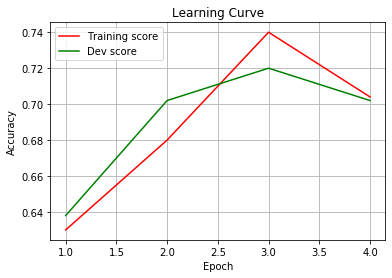

In [0]:
import numpy as np
# grid Search for lr and l2 over the model trained with 5 epochs (cost 5^3 combinations) brute force algorithm

lr = np.linspace(0.01,2,5) # real range (0.01  ..  2) with 5 points lr
l2 = np.linspace(0.01,2,5) # real range (0.01  ..  2) with 5 points l2

# optimization parameters
best_dev = 0
best_Lr = 0
best_L2 = 0
epoch = 5
# brute force searching (may be improved)
for currentL2 in l2:
  for currentLr in lr:
    classifier = logistic_regression_classifier(dim, currentLr, currentL2, epoch)
    train_acc, dev_acc, epochs = classifier.train(training_set, dev_set)
    if  dev_acc[len(dev_acc)-1] > best_dev:
      best_dev = dev_acc[len(dev_acc)-1]
      best_L2 = currentL2
      best_Lr = currentLr

print("\n\nbest parameters found: Learning rate = {} and regularizer L2 {}".format(best_Lr,best_L2))

# train real model with 50 epochs and the optimal parameters
epoch = 50
optimal_classifier = logistic_regression_classifier(dim, best_Lr, best_L2, epoch)
train_acc, dev_acc, epochs = optimal_classifier.train(training_set, dev_set)
plt = plot_learning_curve(epochs, train_acc, dev_acc, xlab="Epoch")
plt.show()

And evaluate it.

In [0]:
evaluate_classifier(optimal_classifier.classify, test_set)

0.6787479406919276

## Assignments

### Our goals
  1. **Pick an effective learning rate**:
      - You could set up the learning rate value by passing it as argument (e.g. in `__init__ (self, dim, lr=1.0, ...)` )
      - Try small and larger values to see the behavior of the model.
  
  2. **Implement L2 regularization:**
      - Hint: Add regularization term to overal cost (`self.cost`)
      - Tensorflow already built in method for this. Check the API to find out. 
      - (Optionaly) Code it without using the built in tool for it

  3. **Pick an effective L2 weight:**
      - You could set up the learning rate value by passing it as argument (e.g. in `__init__ (self, dim, lw=1.0, ...)` )
      - Try small and larger values to see the behavior of the model.
  
  4. **Look at some learning curves:**
      - This code might be helpful: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html


# Team members: 
Edgar Andrés

Mohammed Yassin

Xaidé Caceres

Radostina Peteva

# Atribution:
Adapted by Oier Lopez de Lacalle and Olatz Perez de Viñaspre, based on a notebook by Sam Bowman at NYU